<a href="https://colab.research.google.com/github/auroramugnai/ArXivClassification/blob/main/ArXivClassification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/ArXivClassification.git
%cd ArXivClassification/ArXivClassification

Cloning into 'ArXivClassification'...
remote: Enumerating objects: 1806, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 1806 (delta 340), reused 366 (delta 289), pack-reused 1358
Receiving objects: 100% (1806/1806), 32.10 MiB | 14.33 MiB/s, done.
Resolving deltas: 100% (955/955), done.
/content/ArXivClassification/ArXivClassification


# 1) Build the dataset

In [4]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [5]:
SEED = 42 # fix random seed for reproducibility
random.seed(SEED)

## 1.1 Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [6]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 23% 304M/1.28G [00:01<00:06, 161MB/s]
User cancelled operation


Unzip the downloaded file.

In [7]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

BadZipFile: File is not a zip file

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [ ]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

## 1.2 Get rid of some unnecessary infomation

In [ ]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.head()

Visualize the dataset distribution.

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

## 1.3 Keep 20 categories

In [ ]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # Keep only a subset of C.
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
check = lambda x: set(x).issubset(sub_C)
df = df.loc[df["category"].apply(check).loc[lambda x: x].index]
df = df.reset_index(drop=True)
df.head()

## 1.4 Remove categories with < m samples
First, find categories that have less than m samples, namely "categs_to_drop".
Then, keep articles whose lists of categories have no intersection with "categs_to_drop".


In [ ]:
m = 100
categs_to_drop = [categ for categ,count in dict_counts_exp.items() if count<m]

utils.categories_as_lists(df) # take "category" as a column of lists
has_no_intersection = lambda x: not (set(x) & set(categs_to_drop))
df = df.loc[df["category"].apply(has_no_intersection).loc[lambda x: x].index]

df = df.reset_index(drop=True)
print(f'Number of articles in the dataset: {len(df)}')
df.tail()

Visualize the dataset distribution.

In [ ]:
# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
_ = utils.plot_df_counts(df_exp, col="category")

# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")

# 2) Text-processing

In [9]:
!pip install -U spacy -q
!python -m spacy download en_core_web_md -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
import en_core_web_md
import spacy
from tqdm import tqdm

Clean out the strings (this step will take a while).

In [ ]:
# Remove stop words, punctuation, special characters, numbers.
nlp = spacy.load("en_core_web_md")
tqdm.pandas() # to display progress bar

# First on abstracts.
abs_cleaner = lambda x: utils.text_cleaner(text=x["abstract"], nlp=nlp)
df["clean_abstract"] = df.progress_apply(abs_cleaner, axis=1)

# Then on titles.
tit_cleaner = lambda x: utils.text_cleaner(text=x["title"], nlp=nlp)
df["clean_title"] = df.progress_apply(tit_cleaner, axis=1)

df.tail()

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)
100%|██████████| 18241/18241 [02:22<00:00, 128.03it/s]


,id,title,category,abstract,clean_abstract,clean_title
18236,2405.05896,A note on the volume entropy on a harmonic man...,['math.DG'],Harmonic manifolds of hypergeometric type fo...,harmonic manifold hypergeometric type form cla...,note volume entropy harmonic manifold hypergeo...
18237,2405.05960,The effects of bar strength and kinematics on ...,['astro-ph.GA'],We study how bar strength and bar kinematics...,study bar strength bar kinematic affect star f...,effect bar strength kinematic galaxy evolution...
18238,cond-mat/0403559,Quantum Dark Soliton: Non-Perturbative Diffusi...,['cond-mat.mes-hall'],The dark soliton solution of the Gross-Pitae...,dark soliton solution gross pitaevskii equatio...,quantum dark soliton non perturbative diffusio...
18239,cond-mat/0404352,Scaling dependence on time and distance in non...,['cond-mat.soft'],"Recently, fractional derivatives have been e...",recently fractional derivative employ analyze ...,scale dependence time distance nonlinear fract...
18240,math/0510057,Cryptography and Encryption,['math.CT'],"In cryptography, encryption is the process o...",cryptography encryption process obscure inform...,cryptography encryption


In [ ]:
# Add a space to separate title and abstract.
df["clean_text"] = df["clean_title"] + " " + df["clean_abstract"]

# 3) Multilabel Classification
Given an article:
- its feature X will be the cleaned text
- its label y will be its lists of categories (in a one-hot-encoding)

In [ ]:
!pip install iterative-stratification
!pip install neattext
!pip install scikit-multilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer, normalize
from sklearn.svm import SVC, LinearSVC

from yellowbrick.classifier import ClassificationReport

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [13]:
path = "/content/dati_completi_12maggio.csv"
df = pd.read_csv(path, dtype=str)
print(len(df))
df.tail()

## 3.1 Prepare features

Given an article:
- if features = "keywords", its feature will be the list of its keywords
- if features = "clean_text", its feature will be the clean text (abstract + title)


In [ ]:
features = "clean_text"
# features = "keywords"

if features == "clean_text":
    # Preparing X (features).
    X = df["clean_text"]


elif features == "keywords":
    !pip install KeyBERT -q
    !pip install keyphrase-vectorizers -q
    from keybert import KeyBERT
    from sklearn.feature_extraction.text import TfidfVectorizer

    kw_model = KeyBERT('all-mpnet-base-v2')

    extraction = lambda x: utils.extract_kws(text=x["clean_text"],
                                             kw_model=kw_model,
                                             seed=x["clean_title"].split(" "))

    df["keywords"] = df.progress_apply(extraction, axis=1)
    X = df["keywords"].map(lambda x: " ".join(x))

X = X.to_numpy()

## 3.2 Prepare labels.

Given an article:
- its label y will be its lists of categories (in a one-hot-encoding)

In [ ]:
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # y is now one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding

# Visualize y
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.HE,astro-ph.SR,cond-mat.str-el,cond-mat.supr-con,cs.RO,eess.IV,gr-qc,hep-ph,math.FA,math.PR,math.RT,nlin.CG,physics.ao-ph,physics.app-ph,physics.comp-ph,physics.soc-ph,q-bio.MN,q-fin.MF,q-fin.TR
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26904,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
26905,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
26906,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
26907,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## 3.3 Do the classification with the best train/test split.

In [ ]:
msss = MultilabelStratifiedShuffleSplit(n_splits=3, test_size=0.4,
                                        random_state=SEED)

ovr = OneVsRestClassifier(LinearSVC(class_weight='balanced'),
                          n_jobs=-1)

model = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                  ('svm_model', ovr)])

f0 = 0
best_f = 0
for train_index, test_index in msss.split(X, y):
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
   y_pred, mat = utils.run_model(model, X_train, X_test, y_train, y_test,
                                 multilabel=True)

   f = f1_score(y_test, y_pred, average='weighted')
   print(f'f1_weighted = {round(f,3)}')

   if f>f0:
       best_f = f
       best_X_train, best_X_test = X_train, X_test
       best_y_train, best_y_test = y_train, y_test
       best_y_pred, best_mat = y_pred, mat

   f0 = best_f

print(f'best f1_weighted = {round(best_f,3)}\n')

f1_weighted = 0.905
f1_weighted = 0.905
f1_weighted = 0.902
best f1_weighted = 0.905



## 3.4 Show results.

See the classification report.

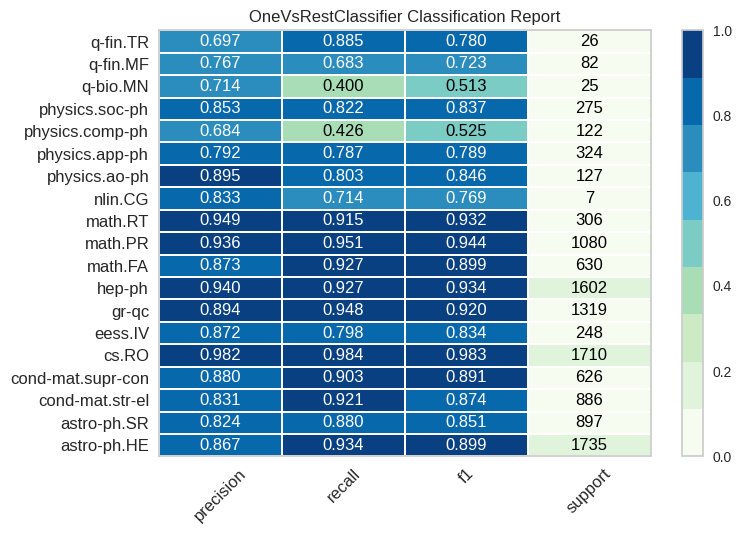

<Axes: title={'center': 'OneVsRestClassifier Classification Report'}>

In [ ]:
visualizer = ClassificationReport(model, classes=classes, support=True, cmap='GnBu')
visualizer.fit(best_X_train, best_y_train)
visualizer.score(best_X_test, best_y_test) # evaluate the model on the test data
visualizer.show()

Plot confusion matrices.

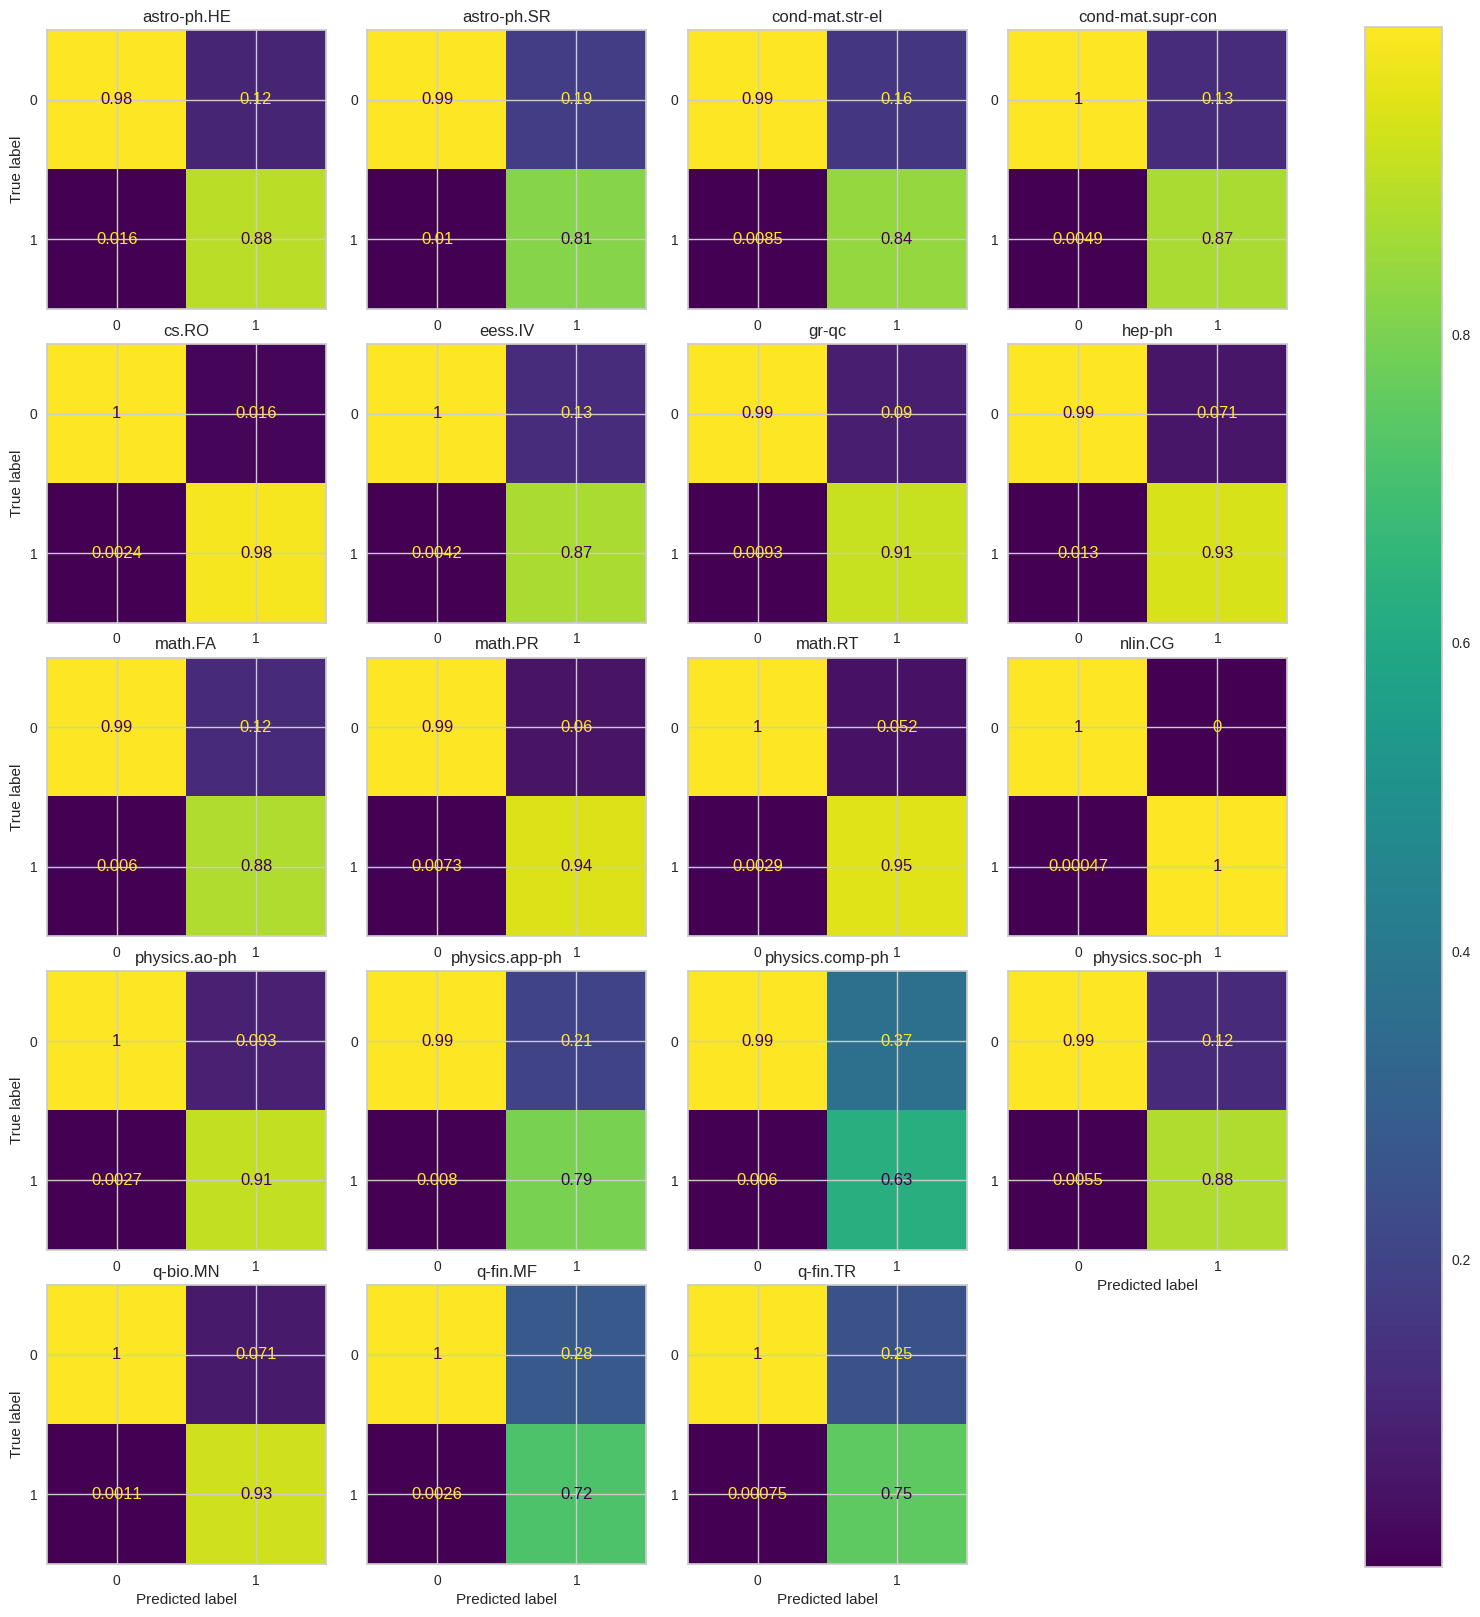

In [ ]:
utils.plot_confusion_matrices(mat, classes)

(Optional) Show some predictions.

In [ ]:
# Check the first 10 predictions.
y_test_list = mlb.inverse_transform(y_test)[:10]
y_pred_list = mlb.inverse_transform(y_pred)[:10]

for yt, yp in zip(y_test_list, y_pred_list):
  print("-"*20)
  print(f"  true   : {yt}")
  print(f"predicted: {yp}")

--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc',)
--------------------
  true   : ('math.RT',)
predicted: ('math.RT',)
--------------------
  true   : ('math.PR',)
predicted: ('math.PR',)
--------------------
  true   : ('math.PR',)
predicted: ('math.PR',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)
--------------------
  true   : ('gr-qc',)
predicted: ('gr-qc',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)
--------------------
  true   : ('cond-mat.str-el', 'cond-mat.supr-con')
predicted: ('cond-mat.supr-con',)
--------------------
  true   : ('hep-ph',)
predicted: ('hep-ph',)


Plot the ROC curve.

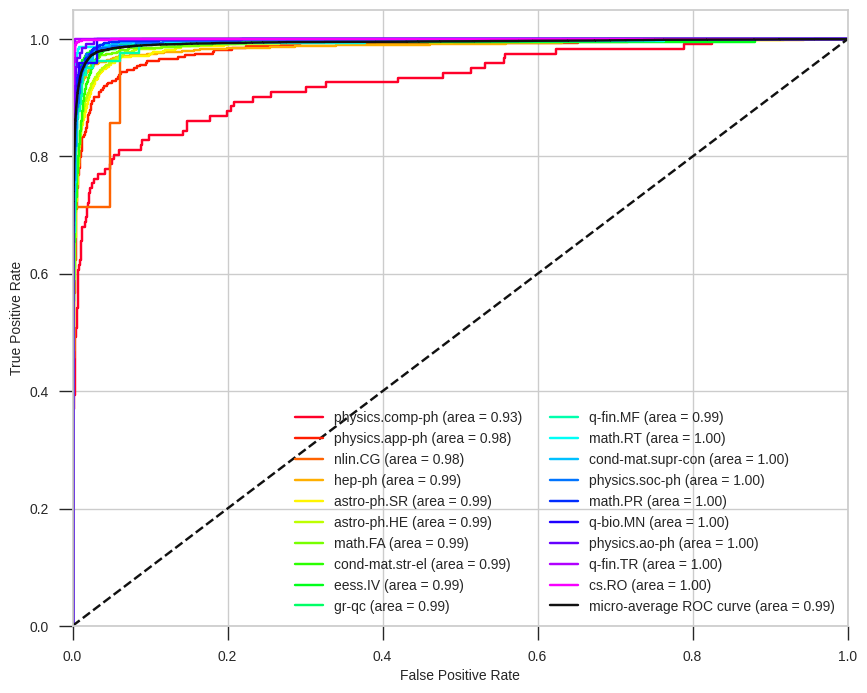

In [ ]:
y_score = model.fit(X_train, y_train).decision_function(X_test)
utils.ROC(classes, y_test, y_score)

Plot the Precision-Recall curve.

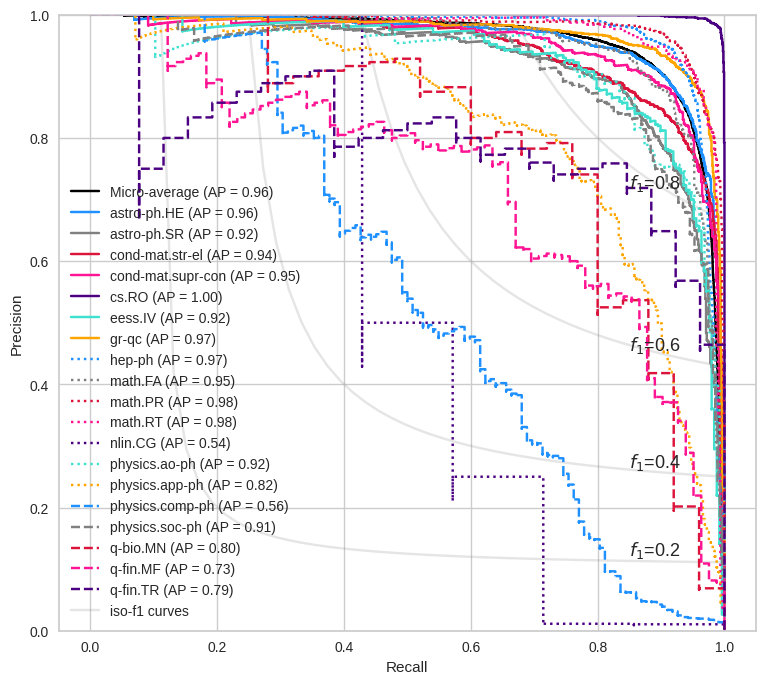

In [ ]:
utils.PRC(classes, y_test, y_score)